In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os, sys

root_path = os.path.dirname(os.getcwd())
sys.path.append(root_path)
data_path = os.path.join(root_path, 'data')
model_path = os.path.join(root_path, 'models')

In [3]:
df = pd.read_csv(os.path.join(data_path, 'processed', 'processed.csv'), encoding='utf-8', parse_dates=['date'] )
df.delitos = df.delitos.astype(int)
df.head()

,cod_lugar,cod_subtipo,date,delitos
0,10001-10,R-0,2015-01-01,0
1,10001-10,R-0,2015-02-01,0
2,10001-10,R-0,2015-03-01,0
3,10001-10,R-0,2015-04-01,0
4,10001-10,R-0,2015-05-01,1


In [4]:
df.dtypes

cod_lugar              object
cod_subtipo            object
date           datetime64[ns]
delitos                 int32
dtype: object

In [5]:
df_piv = df.pivot_table(index='date', columns='cod_subtipo', values='delitos', aggfunc='sum')
df_piv.reset_index(inplace=True)
df_piv.columns.name = None
df_piv.set_index('date', inplace=True)
df_piv.head() 

,R-0,R-1,R-10,R-11,R-12,R-13,R-14,R-15,R-16,R-17,R-2,R-3,R-4,R-5,R-6,R-7,R-8,R-9
date,,,,,,,,,,,,,,,,,,
2015-01-01,3720,6291,443,9,3532,271,20,0,22,7016,374,0,274,228,3097,77,51,836
2015-02-01,3385,5811,409,20,3326,249,19,0,1,6982,356,0,321,243,2946,85,68,765
2015-03-01,3582,6055,443,6,3581,238,14,0,0,7563,524,1,392,247,3196,35,88,852
2015-04-01,3584,5428,402,13,3457,196,15,0,2,6985,534,0,316,201,2951,84,82,818
2015-05-01,3555,5640,486,11,3122,202,13,2,3,7398,574,0,440,207,3206,83,83,652


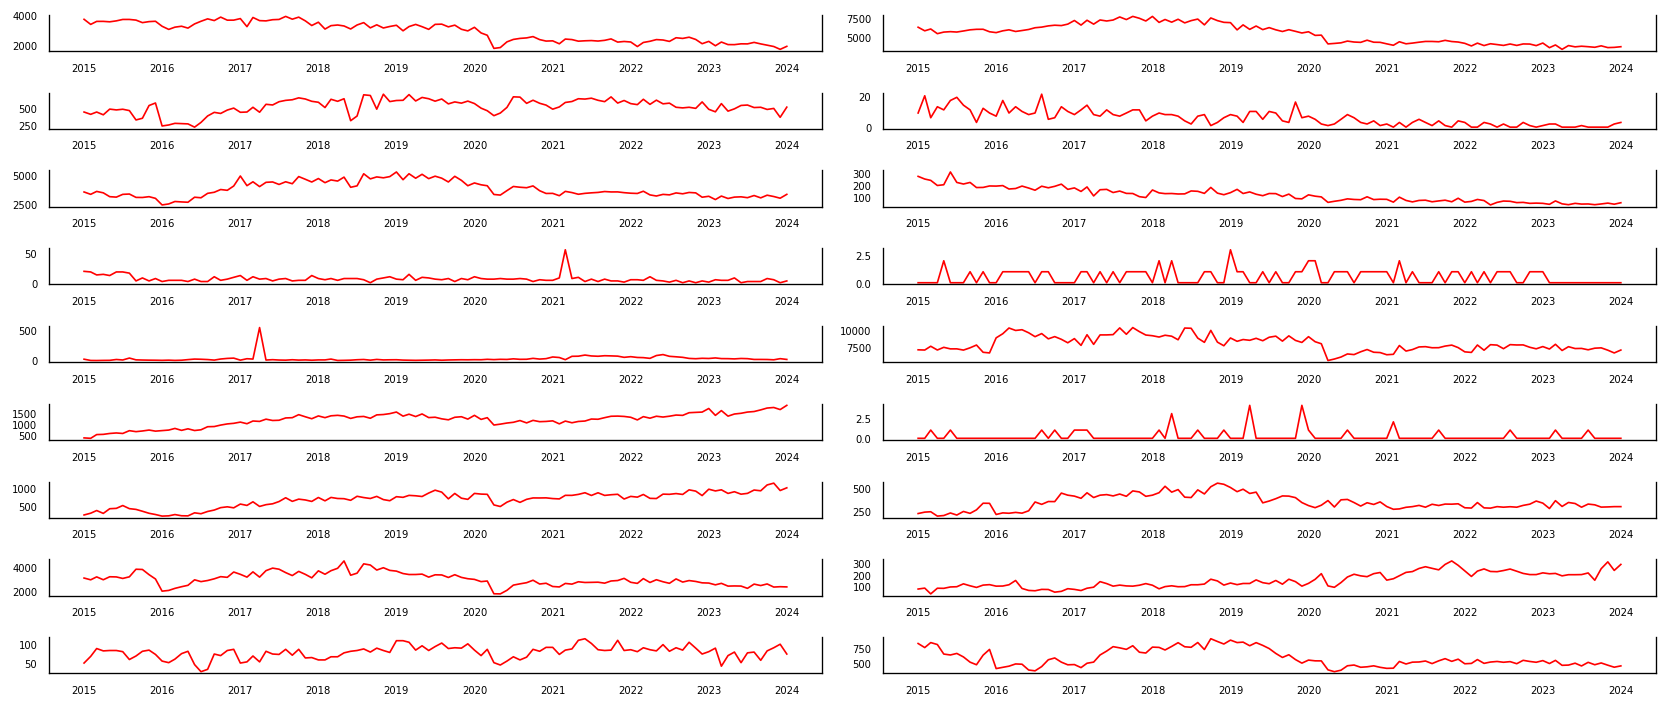

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=9, ncols=2, dpi=120, figsize=(14,6))
for i, ax in enumerate(axes.flatten()):
    data = df_piv[df_piv.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
    plt.tight_layout()

Probemos VARIMA, es exactamentente el mismo enfoque anterior lo que en lugar de ajustar un modelo autoregresivo, ajustamos un ARIMA

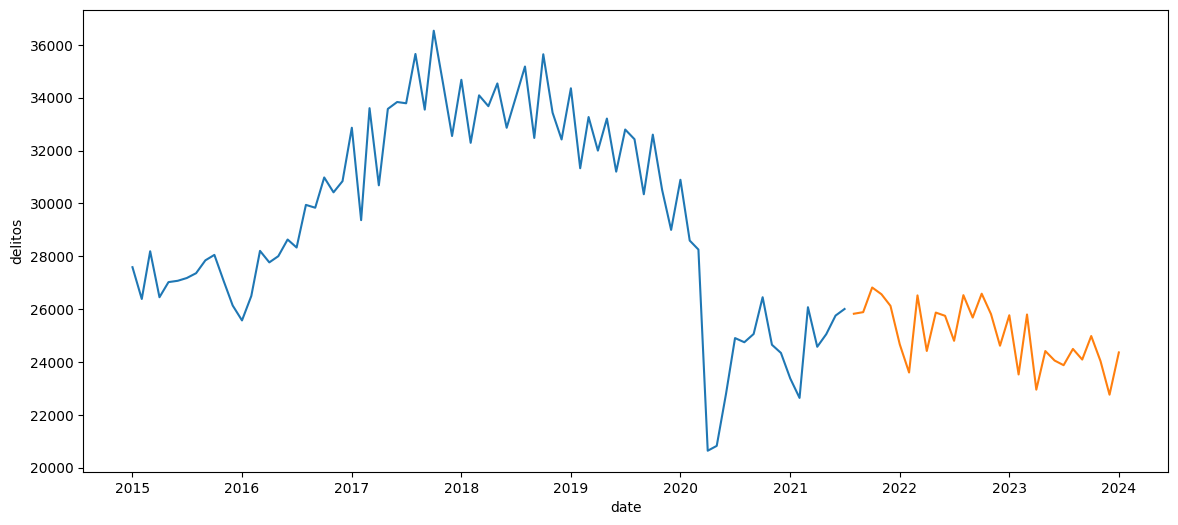

In [48]:
train_agg = train.groupby('date', as_index=False).agg(
    delitos = ('delitos', 'sum')
)

test_agg = test.groupby('date', as_index=False).agg(
    delitos = ('delitos', 'sum')
)

plt.figure(figsize=(14, 6))
ax = sns.lineplot(data=train_agg, x = 'date', y = 'delitos')
ax = sns.lineplot(data=test_agg, x = 'date', y = 'delitos')
ticks = ax.get_xticks()
plt.show()

Vamos a probar un Modelo ARIMA para encontrar los robos en los proximos meses. Para esto vamos a encontrar los parámetros $p$, $d$ y $q$. 

In [49]:
train_agg_serie = train_agg.set_index('date').delitos
test_agg_serie  = test_agg.set_index('date').delitos

In [11]:
from statsmodels.tsa.stattools import adfuller

# Función para realizar la prueba de estacionariedad
def test_stationarity(serie):
    result = adfuller(serie)
    print('Resultado de la prueba de Dickey-Fuller:')
    print('Estadística de prueba:', result[0])
    print('Valor p:', result[1])
    
    if result[1] <= 0.05:
        print("Conclusion: La serie temporal es estacionaria")
    else:
        print("Conclusion: La serie temporal no es estacionaria")

In [50]:
test_stationarity(train_agg_serie.dropna())

Resultado de la prueba de Dickey-Fuller:
Estadística de prueba: -2.0320500035587847
Valor p: 0.2726994520823136
Conclusion: La serie temporal no es estacionaria


In [51]:
test_stationarity(train_agg_serie.diff().dropna())

Resultado de la prueba de Dickey-Fuller:
Estadística de prueba: -1.6670653954667563
Valor p: 0.4481562327170674
Conclusion: La serie temporal no es estacionaria


In [52]:
test_stationarity(train_agg_serie.diff().diff().dropna())

Resultado de la prueba de Dickey-Fuller:
Estadística de prueba: -4.557650705957168
Valor p: 0.0001544880966851674
Conclusion: La serie temporal es estacionaria


d = 2

In [15]:
d_set = [2]

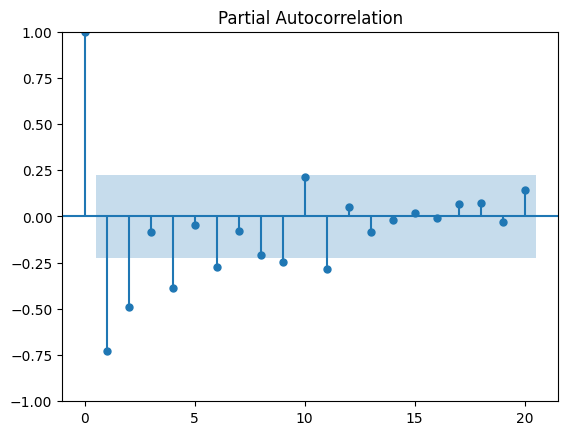

In [16]:
import statsmodels.api as sm

sm.graphics.tsa.plot_pacf(train_agg_serie.diff().diff().dropna(), lags=20)
plt.show()

In [18]:
p_set = [0, 1, 2, 4, 6, 8, 9, 10, 11]

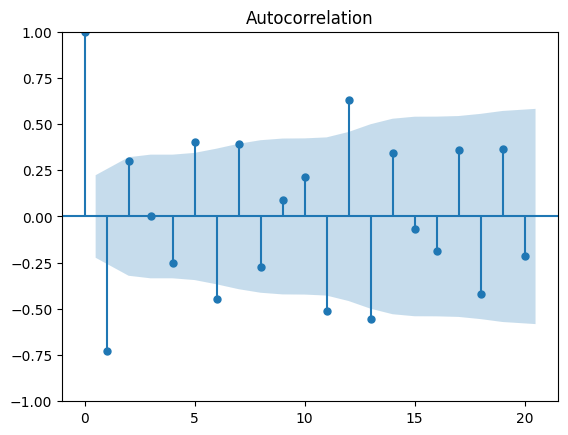

In [17]:
sm.graphics.tsa.plot_acf(train_agg_serie.diff().diff().dropna(), lags=20)
plt.show()

In [19]:
q_set = [0, 1, 2, 4, 5, 6, 7, 8, 11, 12, 13] 

In [22]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from mango import scheduler, Tuner


def arima_objective_function(args_list):
    global train_serie, test_serie
    
    params_evaluated = [] 
    results = []
    
    for params in args_list:
        try:
            p,d,q = params['p'],params['d'], params['q']
            trend = params['trend']
            
            model = ARIMA(train_serie, order=(p,d,q), trend = trend)
            model_fit = model.fit()
            
            preds = pd.DataFrame(model_fit.forecast(steps=len(test_serie)))
            preds['date'] = pd.DataFrame(preds).index.astype(str)
            preds.set_index('date', inplace=True)
            preds = preds.predicted_mean
            mse = mean_squared_error(test_serie.values, preds.values)   
            params_evaluated.append(params)
            results.append(mse)
        except:
            params_evaluated.append(params)
            results.append(1e10)
    return params_evaluated, results

In [23]:
param_space = dict(p = p_set,
                   d = [2],
                   q = q_set,
                   trend = ['n', 'c', 't', 'ct'],
                  )

In [24]:
conf_Dict = dict()
conf_Dict['num_iteration'] = len(p_set)*len(q_set)*4
train_serie, test_serie = train_agg_serie, test_agg_serie
tuner = Tuner(param_space, arima_objective_function, conf_Dict)
results = tuner.minimize()
print('best parameters:', results['best_params'])
print('best loss:', results['best_objective'])

Best score: 903748.7336443913: 100%|██████████| 396/396 [13:17<00:00,  2.01s/it]

best parameters: {'d': 2, 'p': 9, 'q': 4, 'trend': 'n'}
best loss: 903748.7336443913


In [25]:
del train_serie, test_serie

In [53]:
params = results['best_params']
p,d,q = params['p'],params['d'], params['q']
trend = params['trend']

In [54]:
model = ARIMA(train_agg_serie, order=(p,d,q), trend = trend)
model_fit = model.fit()
preds = pd.DataFrame(model_fit.forecast(steps=len(test_agg_serie)))
preds['date'] = pd.DataFrame(preds).index
preds.set_index('date', inplace=True)
preds = preds.predicted_mean

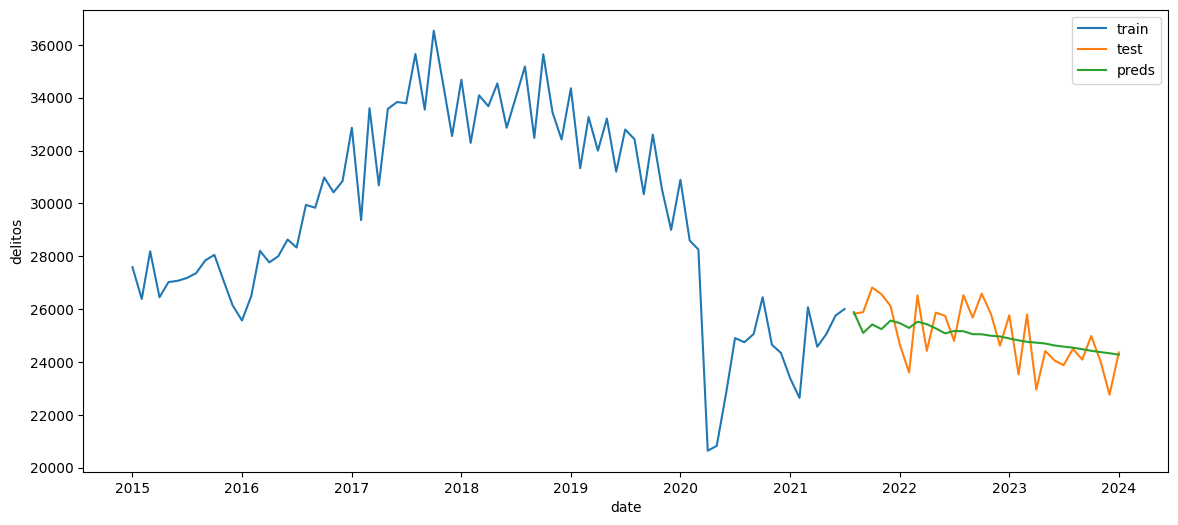

In [56]:
plt.figure(figsize=(14, 6))
ax = sns.lineplot(data=train_agg_serie, label='train')
ax = sns.lineplot(data=test_agg_serie, label='test')
ax = sns.lineplot(data=preds, label='preds')

plt.legend()
plt.show()

In [58]:
mean_squared_error(test_agg_serie.values, preds.values)

903748.7336443913

In [59]:
all_agg_serie = pd.concat([train_agg_serie, test_agg_serie])
train_agg_stand_serie = train_agg_serie.sub(all_agg_serie.mean()).div(all_agg_serie.std())
test_agg_stand_serie = test_agg_serie.sub(all_agg_serie.mean()).div(all_agg_serie.std())

In [60]:
train_serie = train_agg_stand_serie
test_serie  = test_agg_stand_serie

In [61]:
test_stationarity(train_serie.dropna().dropna())

Resultado de la prueba de Dickey-Fuller:
Estadística de prueba: -2.0320500035587887
Valor p: 0.272699452082312
Conclusion: La serie temporal no es estacionaria


In [62]:
test_stationarity(train_serie.dropna().diff().dropna())

Resultado de la prueba de Dickey-Fuller:
Estadística de prueba: -1.6670653954667547
Valor p: 0.4481562327170683
Conclusion: La serie temporal no es estacionaria


In [63]:
test_stationarity(train_serie.dropna().diff().diff().dropna())

Resultado de la prueba de Dickey-Fuller:
Estadística de prueba: -4.557650705957211
Valor p: 0.00015448809668514013
Conclusion: La serie temporal es estacionaria


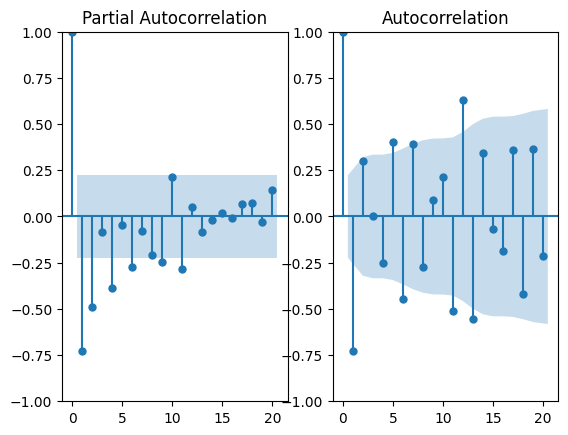

In [64]:
fig, axs =  plt.subplots(ncols=2)
sm.graphics.tsa.plot_pacf(train_serie.diff().diff().dropna(), lags=20, ax=axs[0])
sm.graphics.tsa.plot_acf(train_serie.diff().diff().dropna(), lags=20, ax=axs[1])
plt.show()

In [65]:
p_set = [0,1,2,4,6,8,9,10,11]
q_set = [0,1,2,5,6,7,11,12,13]

In [119]:
param_space = dict(p = p_set,
                   d = [2],
                   q = q_set,
                   trend = ['n', 'c', 't', 'ct'],
                  )

conf_Dict = dict()
conf_Dict['num_iteration'] = len(p_set)*len(q_set)*4
tuner = Tuner(param_space, arima_objective_function, conf_Dict)
results = tuner.minimize()
print('best parameters:', results['best_params'])
print('best loss:', results['best_objective'])

params = results['best_params']
p,d,q = params['p'],params['d'], params['q']
trend = params['trend']

Best score: 10000000000.0:   0%|          | 0/324 [00:00<?, ?it/s]

Best score: 0.04179995237584623: 100%|██████████| 324/324 [02:59<00:00,  1.80it/s]

best parameters: {'d': 2, 'p': 6, 'q': 6, 'trend': 'n'}
best loss: 0.04179995237584623


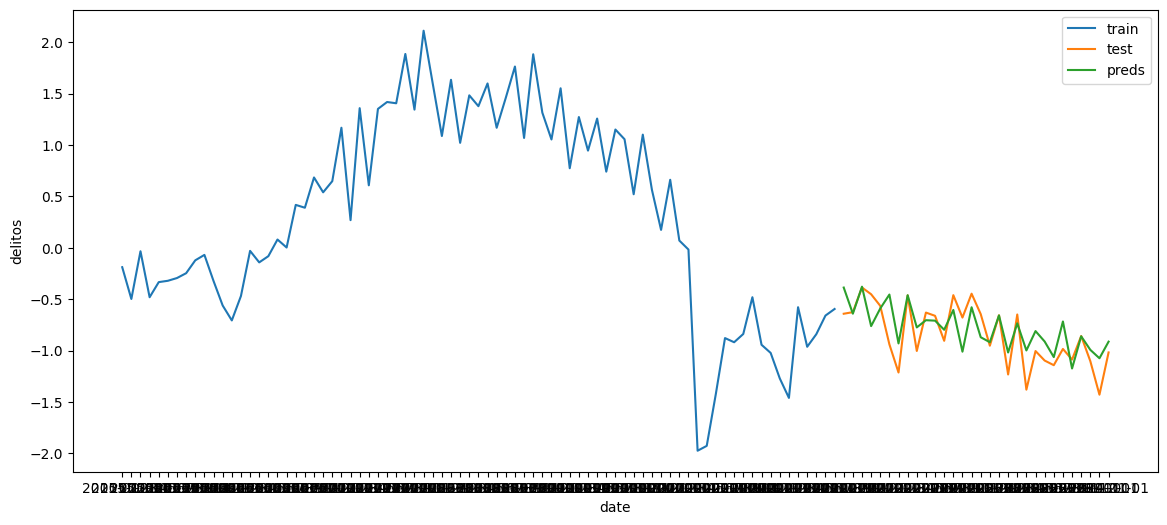

In [121]:
model = ARIMA(train_serie, order=(p,d,q), trend=trend)
model_fit = model.fit()
preds = pd.DataFrame(model_fit.forecast(steps=len(test_serie)))
preds['date'] = pd.DataFrame(preds).index
preds.set_index('date', inplace=True)
preds = preds.predicted_mean

plt.figure(figsize=(14, 6))
ax = sns.lineplot(data=train_serie, label='train')
ax = sns.lineplot(data=test_serie, label='test')
ax = sns.lineplot(data=preds, label='preds')

plt.legend()
plt.show()

ARIMA funciona de forma aceptable para los datos estandarizados. 

In [125]:
import json

file_name = os.path.join(data_path, 'parameters.json')

# Cargar el contenido existente del archivo
with open(file_name, 'r') as json_file:
    data = json.load(json_file)

# Agregar nuevo contenido al diccionario existente
data["param_stand_all"] = {"mean": all.mean(),
                           "std": all.std() }

data["param_stand_arima"] = {'d': d,
                             'p': p,
                             'q': q, 
                             'trend': trend} 

# Escribir el contenido actualizado en el archivo JSON
with open(file_name, 'w') as json_file:
    json.dump(data, json_file, indent=4)

In [66]:
all

,loc,subtipo,date,delitos
0,0,0,2015-01-01,88.0
1,0,0,2015-02-01,77.0
2,0,0,2015-03-01,90.5
3,0,0,2015-04-01,81.0
4,0,0,2015-05-01,87.0
...,...,...,...,...
1339501,2482,17,2023-09-01,0.0
1339502,2482,17,2023-10-01,0.0
1339503,2482,17,2023-11-01,0.0
1339504,2482,17,2023-12-01,0.0


In [67]:
all_agg_stand_serie = all_agg_serie.sub(all_agg_serie.mean()).div(all_agg_serie.std())

In [128]:
model = ARIMA(all_agg_stand_serie, order=(p,d,q), trend=trend)
model_fit = model.fit()

In [129]:
model_fit.save(os.path.join(root_path,'models', 'arima.pkl'))

Aquí no acaba esto, devemos ahora saber que hacer para diferenciar entre los posibles lugares y posibles subtipos de delitos. Movamonos a la siguiente notebook

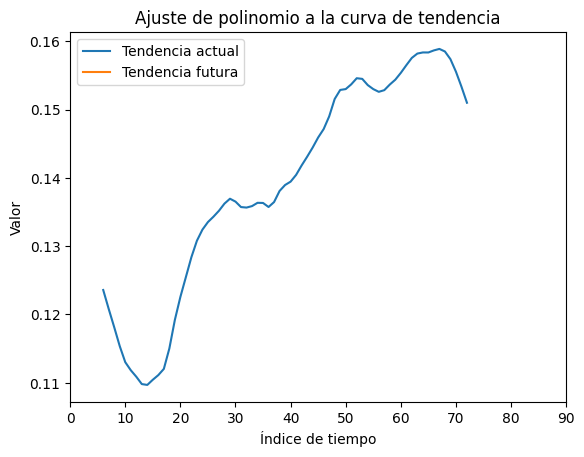

In [189]:

indices_tiempo = np.arange(len(tendencia))

coeficientes = np.polyfit(indices_tiempo, tendencia, deg=3)
polinomio = np.poly1d(coeficientes)

pasos_futuros = 10  
indices_futuros = np.arange(len(tendencia), len(tendencia) + pasos_futuros)
tendencia_futura = polinomio(indices_futuros)

plt.plot(indices_tiempo, tendencia, label='Tendencia actual')
plt.plot(indices_futuros, tendencia_futura, label='Tendencia futura')
plt.xlim(0,90)
plt.title('Ajuste de polinomio a la curva de tendencia')
plt.xlabel('Índice de tiempo')
plt.ylabel('Valor')
plt.legend()
plt.show()

In [188]:
indices_futuros

array([79, 80, 81, 82, 83, 84, 85, 86, 87, 88])

In [190]:
tendencia_futura

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])